In [1]:
from p_tqdm import p_map
import hdbscan
import umap
import numpy as np
import pandas as pd 
import soundfile as sf
from scipy.signal import hilbert, hamming, butter, sosfiltfilt, windows, spectrogram
from scipy.interpolate import CloughTocher2DInterpolator
from p_tqdm import p_map
from tqdm import tqdm
from tftb.processing import WignerVilleDistribution, PseudoWignerVilleDistribution
from tftb.processing.ambiguity import wide_band
import matplotlib.pyplot as plt
from bokeh.plotting import output_file, save
from io import BytesIO
from PIL import Image
import base64
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper, ColorBar
from bokeh.palettes import Spectral10, Category10, Category20, turbo
from sklearn.preprocessing import StandardScaler, QuantileTransformer, normalize, Normalizer
from sklearn.cluster import KMeans
from bokeh.io import curdoc
from bokeh.transform import linear_cmap
import umap.plot 

/home/nicolas.deloustal/.local/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/nicolas.deloustal/.local/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/nicolas.deloustal/.local/lib/python3.9/site-packages/umap/distances.py:108

In [2]:
def center(sig,n,val):
	if val == 0 :
		a_max = np.argmax(np.abs(sig))
		sig = sig[a_max-n:a_max+n]
	else :
		sig = sig[n*2-n:n+n*2] 
	return sig

In [58]:
def pwvf(dc, win, channel):
	arr = np.empty((len(dc), (win*2) * (win*2)))  #wvd.tfr.shape 2048 si 2ms
	ar = np.empty((len(dc), (win*2), (win*2)))
	path = '../../LT_3_voies_son_28-09/valide/'
    
	for x in tqdm(range(len(dc))):
	#1ms avant et apres le clic /!\ si change ms change aussi arr shape
		try:
			#sig, sr = sf.read(path + dc.file.iloc[x].split('/')[-1], start=int(dc.pos.iloc[x]-0.001*512000), stop=int(dc.pos.iloc[x]+0.001*512000))
			sig, sr = sf.read(dc.file.iloc[x].split('/')[-1], start=int(dc.pos.iloc[x]-0.001*512000), stop=int(dc.pos.iloc[x]+0.001*512000))
			sos = butter(3, 10000 * 2 / sr, 'hp', output='sos')
			sig = sosfiltfilt(sos, sig[:,channel])
			sig = sig * windows.tukey(len(sig), alpha=0.6, sym=False)
			sig = center(sig, win, 0)
			sig = (sig - np.mean(sig)) / np.std(sig)
			sig = hilbert(sig) #voir wiki en [49][B][C]
		except:
			#sig, sr = sf.read(path + dc.file.iloc[x].split('/')[-1], start=int(dc.pos.iloc[x]-0.001*512000), stop=int(dc.pos.iloc[x]+0.001*512000))
			sig, sr = sf.read(dc.file.iloc[x].split('/')[-1], start=int(dc.pos.iloc[x]-0.001*512000), stop=int(dc.pos.iloc[x]+0.001*512000))
			sos = butter(3, 10000 * 2 / sr, 'hp', output='sos')
			sig = sosfiltfilt(sos, sig[:,channel])
			sig = sig * windows.tukey(len(sig), alpha=0.6, sym=False)
			sig = center(sig, win, 1)			
			sig = (sig - np.mean(sig)) / np.std(sig)
			sig = hilbert(sig) 
            
		wvd = PseudoWignerVilleDistribution(sig)
		wvd.run()
        
		arr[x] = np.real(wvd.tfr).flatten() #essayer avec **2  et abs/!\ si change 1 change aussi lautre
		ar[x] = np.real(wvd.tfr)

	return arr, ar

In [4]:
def stftf(dc, win, channel):
	d1, d2 = win*2, win*2
	arr = np.empty((len(dc), d1 * d2))
	ar = np.empty((len(dc), d1, d2)) #tfr[0].shape
    
    
	for x in tqdm(range(len(dc))):
	#1ms avant et apres le clic /!\ si change ms change aussi arr shape
		
		try:
			sig, sr = sf.read(dc.file.iloc[x].split('/')[-1], start=int(dc.pos.iloc[x]-0.001*512000), stop=int(dc.pos.iloc[x]+0.001*512000))
			sos = butter(3, 10000 * 2 / sr, 'hp', output='sos')
			sig = sosfiltfilt(sos, sig[:,channel])
			sig = sig * windows.tukey(len(sig), alpha=0.6, sym=False)
			sig = center(sig, win, 0)
			sig = (sig - np.mean(sig)) / np.std(sig)
		except:
			sig, sr = sf.read(dc.file.iloc[x].split('/')[-1], start=int(dc.pos.iloc[x]-0.001*512000), stop=int(dc.pos.iloc[x]+0.001*512000))
			sos = butter(3, 10000 * 2 / sr, 'hp', output='sos')
			sig = sosfiltfilt(sos, sig[:,channel])
			sig = sig * windows.tukey(len(sig), alpha=0.6, sym=False)
			sig = center(sig, win, 1)
			sig = (sig - np.mean(sig)) / np.std(sig)
            
		tfr = plt.specgram(sig, NFFT=16, noverlap=15, pad_to=127, scale='linear', cmap='jet')
        
        #interpolation pour win*2 x win*2
		rows, cols = tfr[0].shape        
		xx = np.linspace(0, cols - 1, cols)
		y = np.linspace(0, rows - 1, rows)
		xx, y = np.meshgrid(xx, y)
		z = tfr[0]
		X = np.linspace(0, cols - 1, d1)
		Y = np.linspace(0, rows - 1, d2)
		X, Y = np.meshgrid(X, Y)

		interp = CloughTocher2DInterpolator(list(zip(xx.flatten(), y.flatten())), z.flatten()) # sources bicubic interpolation: https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.CloughTocher2DInterpolator.html#scipy.interpolate.CloughTocher2DInterpolator
		Z = interp(X, Y)

		arr[x] = Z.flatten()
		ar[x] = Z
        
	return arr, ar

In [5]:
def fa(dc, win, channel):
    
	arr = np.empty((len(dc), (win*2) * (win*2)))  #wvd.tfr.shape 2048 si 2ms
	ar = np.empty((len(dc), (win*2), (win*2)))
    
	for x in tqdm(range(len(dc))):
		try:
			#sig, sr = sf.read(path + dc.file.iloc[x].split('/')[-1], start=int(dc.pos.iloc[x]-0.001*512000), stop=int(dc.pos.iloc[x]+0.001*512000))
			sig, sr = sf.read(dc.file.iloc[x].split('/')[-1], start=int(dc.pos.iloc[x]-0.001*512000), stop=int(dc.pos.iloc[x]+0.001*512000))
			sos = butter(3, 10000 * 2 / sr, 'hp', output='sos')
			sig = sosfiltfilt(sos, sig[:,channel])
			sig = sig * windows.tukey(len(sig), alpha=0.6, sym=False)
			sig = center(sig, win, 0)
			sig = (sig - np.mean(sig)) / np.std(sig)
		except:
			#sig, sr = sf.read(path + dc.file.iloc[x].split('/')[-1], start=int(dc.pos.iloc[x]-0.001*512000), stop=int(dc.pos.iloc[x]+0.001*512000))
			sig, sr = sf.read(dc.file.iloc[x].split('/')[-1], start=int(dc.pos.iloc[x]-0.001*512000), stop=int(dc.pos.iloc[x]+0.001*512000))
			sos = butter(3, 10000 * 2 / sr, 'hp', output='sos')
			sig = sosfiltfilt(sos, sig[:,channel])
			sig = sig * windows.tukey(len(sig), alpha=0.6, sym=False)
			sig = center(sig, win, 1)
			sig = (sig - np.mean(sig)) / np.std(sig)
            
		waf, tau, theta = wide_band(sig, N=64)
    
		arr[x] = (np.abs(waf)**2).flatten() #essayer avec **2 /!\ si change 1 change aussi lautre
		ar[x] = np.abs(waf)**2
		#print(waf.shape)
	return arr, ar
    

100%|██████████| 1464/1464 [00:45<00:00, 32.18it/s]


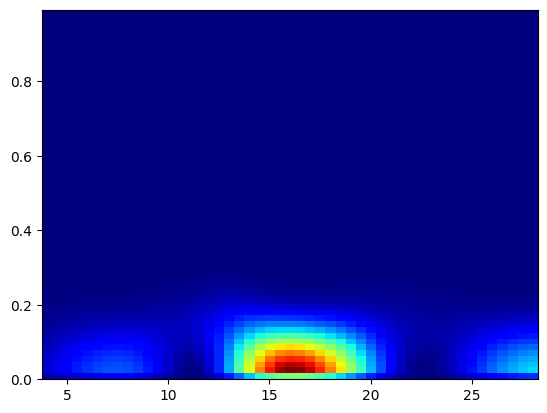

In [61]:
sr = 512000
win = 32

df = pd.read_csv('clicks_quadra.csv')

c = pd.DataFrame(columns = ['file'])
c['file'] = df.file
c['pos'] = df.pos

arr, ar = pwvf(c, win, 2)
brr, br = stftf(c, win, 2)
#frr, far = fa(c, win, 2)

In [62]:
def th_red(array, percentile, comp):
    thq = np.percentile(array.flatten(), percentile)
    ar2 = array * (array>thq)
    #ar2=array
    
    reducer = umap.UMAP(random_state=0, n_components=comp)
    reducer.fit(ar2)
    embedding = reducer.transform(ar2)
    
    if comp == 2:
        n_df = pd.DataFrame(embedding, columns=('x', 'y'))
        n_df['digit'] = [str(x) for x in (c.pos/512000).round(3)]
        #n_df['image'] = list(map(embeddable_image, arr))
        n_df['rank'] = [str(x) for x in range(len(c.pos))]
        
        
    if comp == 3:
        n_df = pd.DataFrame(embedding, columns=('x', 'y', 'z'))
    
    return ar2, n_df

In [76]:
mrr = arr*brr

arr, emba = th_red(arr, 85, 2)
brr, embb = th_red(brr,85, 2)
#frr, embf = th_red(frr,85, 2)

nmrr, embm = th_red(mrr, 85, 2)

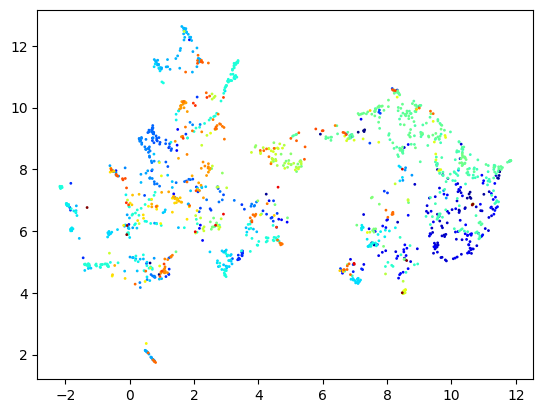

In [65]:
plt.scatter(emba.x,emba.y, 1, c=c.pos, cmap='jet')

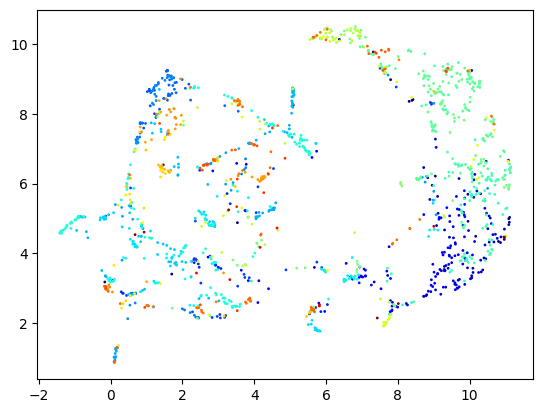

In [66]:
plt.scatter(embb.x,embb.y, 1, c=c.pos, cmap='jet')

In [ ]:
plt.figure(figsize=(12,6))
plt.scatter(embf.x,embf.y, 2, c=c.pos, cmap='jet')

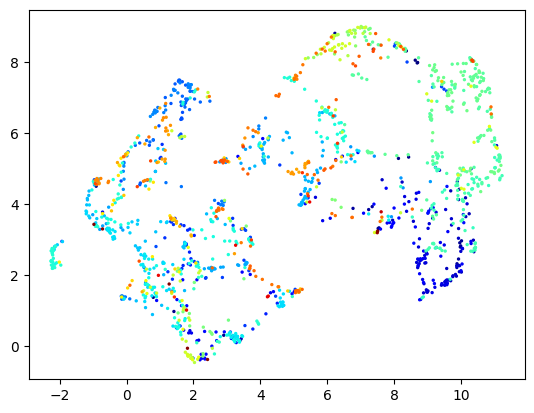

In [74]:
plt.scatter(embm.x,embm.y, 2, c=c.pos, cmap='jet')

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(emba.x,emba.y,emba.z, s=3, c=c.pos, cmap='jet')
plt.show()

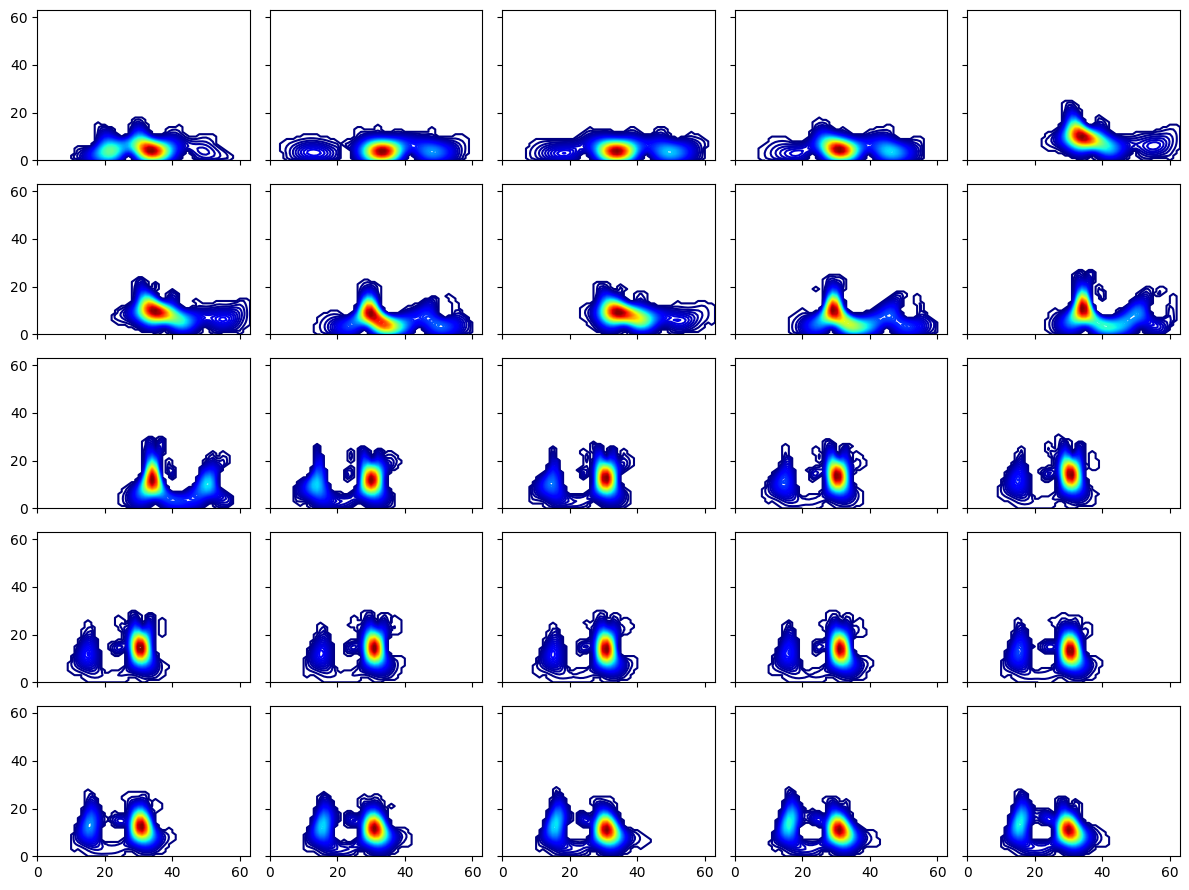

In [77]:
col = 5
lig = 5
pos = 380
p = [23,25,46,47,51,55,59,63,66,72,76,78]

fig, axs = plt.subplots(lig, col, figsize=(12, 9), sharex=True, sharey=True)

axes = axs.flatten()
for i, ax in enumerate(axes):
    im = ax.contour(nmrr[i+pos].reshape(win*2,win*2),100, cmap='jet')
    #im = ax.contour(ar2[p[i]].reshape(win*2,win*2),100, cmap='jet', origin='lower')
""""   
y_ticks = np.linspace(0, sr/2, 5)
ax.set_yticks(np.linspace(0, win*2, len(y_ticks)))
ax.set_yticklabels(map(str, y_ticks.astype(int)))

x_ticks = np.linspace(0, win*2/sr, 2)
ax.set_xticks(np.linspace(0, win*2, len(x_ticks)))
ax.set_xticklabels(map(str, x_ticks.astype(float)))
    
# bas x
for ax in axs[-1, :]:
    ax.set_xlabel(' ')

# gauche y
for ax in axs[:, 0]:
    ax.set_ylabel(' ')
"""

plt.tight_layout()


In [ ]:
dc=c
channel=2
x=397

sig, sr = sf.read(dc.file.iloc[x].split('/')[-1], start=int(dc.pos.iloc[x]-0.001*512000), stop=int(dc.pos.iloc[x]+0.001*512000))
sos = butter(3, 10000 * 2 / sr, 'hp', output='sos')
sig = sosfiltfilt(sos, sig[:,channel])
sig = sig * windows.tukey(len(sig), alpha=0.6, sym=False)
sig = center(sig, win, 0)
sig = (sig - np.mean(sig)) / np.std(sig)
waff, tau, theta = wide_band(sig)
waf, tau, theta = wide_band(sig, N=64)


""""
plt.plot(abs(sig))
wvd = PseudoWignerVilleDistribution(hilbert(sig))
wvd.run()
plt.figure()
plt.imshow(np.abs(waff)**2, origin='lower')
plt.figure()
plt.imshow(np.abs(waf)**2, origin='lower')
plt.figure()
plt.magnitude_spectrum(sig)

"""""
plt.plot(sig)
'''
plt.figure()
plt.imshow(arr[397].reshape(64,64), origin='lower')
plt.figure()

#tfr = plt.specgram(g, NFFT=16, noverlap=15, pad_to=127, scale='linear', cmap='jet')
plt.imshow(brr[397].reshape(64,64), origin='lower')

#tfr[0] * np.real(wvd.tfr)
nn = br[397] * ar[397]
plt.figure()
plt.imshow(nn, origin='lower')
'''

spec = WignerVilleDistribution(hilbert(sig))
spec.run()
from tftb.processing.linear import gabor
tfr, dgr, h = gabor(hilbert(sig),64,64)
print(tfr.shape)
mix=spec.tfr*tfr

plt.figure()
plt.imshow(spec.tfr, origin='lower')
plt.figure()
plt.imshow(dgr, origin='lower')
plt.figure()
plt.imshow(mix, origin='lower')




In [ ]:
plt.plot(abs(sig), label='abs(signal)')
posi = np.argmax(sig)
maxi = sig[posi]
plt.scatter(posi, maxi, color='red', marker='x', label='detection')
plt.xlabel('Time in samples')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

In [ ]:
from tftb.utils import nextpow2

dc=c
channel=2
x=20*7

sig, sr = sf.read(dc.file.iloc[x].split('/')[-1], start=int(dc.pos.iloc[x]-0.001*512000), stop=int(dc.pos.iloc[x]+0.001*512000))
sos = butter(3, 10000 * 2 / sr, 'hp', output='sos')
sig = sosfiltfilt(sos, sig[:,channel])
sig = sig * windows.tukey(len(sig), alpha=0.6, sym=False)
sig = center(sig, win, 0)
sig = (sig - np.mean(sig)) / np.std(sig)

m = int(np.round(nx / 2.0))
s_ana = sig
nx=sig.shape[0]
t = np.arange(nx) - m
tmin = 0
tmax = nx - 1
T = tmax - tmin
STF = np.fft.fftshift(s_ana)
sp = np.abs(STF[:m]) ** 2
maxsp = np.amax(sp)
maxsp
f = np.linspace(0, 0.5, m + 1)
f = f[:m]
indmin = np.nonzero(sp > maxsp / 100.0)[0].min()
indmax = np.nonzero(sp > maxsp / 100.0)[0].max()
fmin = max([0.01, 0.05 * np.fix(f[indmin] / 0.05)])
fmax = 0.05 * np.ceil(f[indmax] / 0.05)
B = fmax - fmin
R = B / ((fmin + fmax) / 2.0)
nq = np.ceil((B * T * (1 + 2.0 / R) * np.log((1 + R / 2.0) / (1 - R / 2.0))) / 2.0)
nmin = nq - (nq % 2)
N = int(2 ** (nextpow2(nmin)))

print(nx)
print(N)
print(fmin)
print(fmax)

k = np.arange(1, N + 1)
q = (fmax / fmin) ** (1.0 / (N - 1))
geo_f = fmin * (np.exp((k - 1) * np.log(q)))
tfmatx = -2j * np.dot(t.reshape(-1, 1), geo_f.reshape(1, -1)) * np.pi
tfmatx = np.exp(tfmatx)
S = np.dot(s_ana.reshape(1, -1), tfmatx)
S = np.tile(S, (nx, 1))
Sb = S * tfmatx

tau = t
S = np.c_[S, np.zeros((nx, N))].T
Sb = np.c_[Sb, np.zeros((nx, N))].T

# mellin transform computation of the analyzed signal
p = np.arange(2 * N)
coef = np.exp(p / 2.0 * np.log(q))
mellinS = np.fft.fftshift(np.fft.ifft(S[:, 0] * coef))
mellinS = np.tile(mellinS, (nx, 1)).T

mellinSb = np.zeros((2 * N, nx), dtype=complex)
for i in range(nx):
    mellinSb[:, i] = np.fft.fftshift(np.fft.ifft(Sb[:, i] * coef))

k = np.arange(1, 2 * N + 1)
scale = np.logspace(np.log10(fmin / fmax), np.log10(fmax / fmin), N)
theta = np.log(scale)
mellinSSb = mellinS * np.conj(mellinSb)

waf = np.fft.ifft(mellinSSb, N, axis=0)
no2 = int((N + N % 2) / 2.0)
waf = np.r_[waf[no2:(N + 1), :], waf[:no2, :]]

print(waf.shape)
print(m)
print(nmin)

In [ ]:
s, sr = sf.read(dc.file.iloc[x].split('/')[-1])

fig, axs = plt.subplots(3, sharex=True, sharey=True)
axs[0].plot(s[:,0], c='r')
axs[0].set(ylabel='SQ26 \n Amplitude')
axs[1].plot(s[:,1], c='g')
axs[1].set(ylabel='SQ26 \n Amplitude')
axs[2].plot(s[:,2], c='b')
axs[2].set(xlabel='Time in samples', ylabel='C75 \n Amplitude')
plt.show()


In [ ]:
def embeddable_image(data):
    #scaler = StandardScaler()
    #data = scaler.fit_transform(data)
    
    data = data.reshape(win*2,win*2)
    min_val = np.min(data)
    max_val = np.max(data)
    data = 255 * ((data - min_val) / (max_val - min_val))
    
    img_data = 255-1 * data.astype(np.uint8)
    image = Image.fromarray(np.flipud(img_data), mode='L').resize((64, 64), Image.Resampling.LANCZOS)
    buffer = BytesIO()
    image.save(buffer, format='png')
    for_encoding = buffer.getvalue()
    return 'data:image/png;base64,' + base64.b64encode(for_encoding).decode()

In [ ]:
datasource = ColumnDataSource(emba)
color_mapper = linear_cmap(field_name='rank', palette=turbo(256), low=float(min(emba['rank'])), high=float(max(emba['rank'])))


output_notebook()
curdoc().theme = 'light_minimal'
plot_figure = figure(title='UMAP projection',tools=('pan, wheel_zoom, reset'))

plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <img src='@image' style='float: left; margin: 10px 10px 10px 10px'/>
    </div>
    <div>
        <span style='font-size: 10px; color: #224499'>Position:</span>
        <span style='font-size: 10px'>@digit</span>
        
        <span style='font-size: 10px; color: #224499'>Rank:</span>
        <span style='font-size: 10px'>@rank</span>
    </div>
</div>
"""))

plot_figure.circle('x','y', source=datasource, color=color_mapper, line_alpha=0.7, fill_alpha=0.6, size=5)
show(plot_figure)

In [ ]:
col = 5
lig = 5
pos = 13
p = [23,25,46,47,51,55,59,63,66,72,76,78]

fig, axs = plt.subplots(lig, col, figsize=(12, 9), sharex=True, sharey=True)

axes = axs.flatten()
for i, ax in enumerate(axes):
    im = ax.contour(brr[i*pos].reshape(win*2,win*2),100, cmap='jet')
    #im = ax.contour(ar2[p[i]].reshape(win*2,win*2),100, cmap='jet', origin='lower')
    
y_ticks = np.linspace(0, sr/2, 5)
ax.set_yticks(np.linspace(0, win*2, len(y_ticks)))
ax.set_yticklabels(map(str, y_ticks.astype(int)))

x_ticks = np.linspace(0, win*2/sr, 2)
ax.set_xticks(np.linspace(0, win*2, len(x_ticks)))
ax.set_xticklabels(map(str, x_ticks.astype(float)))
    
# bas x
for ax in axs[-1, :]:
    ax.set_xlabel(' ')

# gauche y
for ax in axs[:, 0]:
    ax.set_ylabel(' ')

plt.tight_layout()